In [2]:
# initialize stuff
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import logging
import importlib

import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

from tqdm import tqdm
from time import time
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from itertools import product

%matplotlib inline

In [3]:
# import theory stuff

%reload_ext autoreload
%autoreload 2

HOME_DIR = "/Users/oliver/Documents/p5control-bluefors-evaluation"
sys.path.append(HOME_DIR)

from utilities.corporate_design_colors_v4 import cmap, colors

from theory.models.functions import bin_y_over_x, oversample

from theory.models.constants import G_0_S, G_0_muS
importlib.reload(sys.modules["theory.models.constants"])

loaded constants...
loaded constants...


<module 'theory.models.constants' from '/Users/oliver/Documents/p5control-bluefors-evaluation/theory/models/constants.py'>

In [4]:
# PAT parameter
# nu_GHz: float = 7.8  # n = many, gap closing
# nu_GHz: float = 8.0 # n = inf, ever so slight gap closing
nu_GHz = 13.6  # n = perfect, slight gap closing
# nu_GHz: float = 15.0 # n = 2, crap
# nu_GHz, V_off = 18.3, -13e-3  # n = okay, slight gap closing
# nu_GHz: float = 19.3 # n = 3, crap

# Initial guessing parameter
tau_0_arbu: float = 0.18861238619219342
T_0_K: float = 0.3
Delta_0_meV: float = 0.1954362246372233
Gamma_0_meV: float = 0.0073389200475204005

# Data
V_mV: NDArray[np.float64] = np.linspace(-2.0, 2.0, 801, dtype="float64")
V_off_range_mV: NDArray[np.float64] = np.linspace(-0.045, 0.045, 451, dtype="float64")

I_nA: NDArray[np.float64] = np.linspace(-30, 30, 601, dtype="float64")
I_off_range_nA: NDArray[np.float64] = np.linspace(-0.35, 0.35, 701, dtype="float64")

# exp_data evaluation
sampling_rate: float = 13.7
window: tuple[int, int] = (0, 0)

# interesting Amplitudes
A_lim: tuple[float, float] = (0, 705)  # mV
A_interest: list[int] = [0, 10, 50, 100, 250, 375, 500]  # mV

# simulation parameter
N: int = 100

In [5]:
# Get exp data
from utilities.ivevaluation import IVEvaluation

importlib.reload(sys.modules["utilities.ivevaluation"])
logger = logging.getLogger()
logger.setLevel(level=logging.WARNING)

eva = IVEvaluation()
eva.file_directory = "/Users/oliver/Documents/measurement data/"
eva.file_folder = "25 04 OI-25c-09/"
eva.file_name = "OI-25c-09 2025-05-02 unbroken stripline irradiation studies 0.hdf5"
eva.sub_folder = ""

eva.setAmplifications(1000, 1000)
eva.setV(
    voltage_minimum=np.min(V_mV) * 1e-3,
    voltage_maximum=np.max(V_mV) * 1e-3,
    voltage_bins=V_mV.shape[0] - 1,
)
eva.eva_current = True
eva.setI(
    current_minimum=np.min(I_nA) * 1e-9,
    current_maximum=np.max(I_nA) * 1e-9,
    current_bins=I_nA.shape[0] - 1,
)
eva.eva_voltage = True

eva.downsample_frequency = sampling_rate

eva.title = f"amplitude at {nu_GHz:.1f}GHz"
eva.setMeasurement(f"vna_amplitudes_{nu_GHz:.1f}000GHz")
eva.setKeys(index_0=-6, index_1=-1, norm=1e0, to_pop="no_irradiation")
eva.addKey("no_irradiation", 0)
eva.addKey("no_irradiation", 0.005)
(eva.up_sweep,) = eva.getMaps([1], y_lim=tuple(np.array(A_lim) * 1e-3), skip=(20, None))
eva.saveData()

# logger.setLevel(level=logging.INFO)
# eva.showMeasurements()
# eva.showKeys()

100%|██████████| 141/141 [00:05<00:00, 23.65it/s]


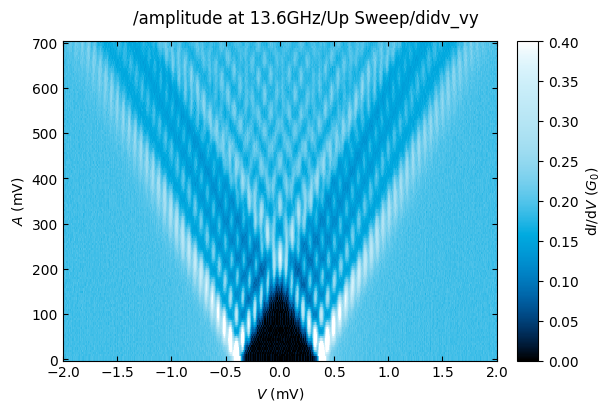

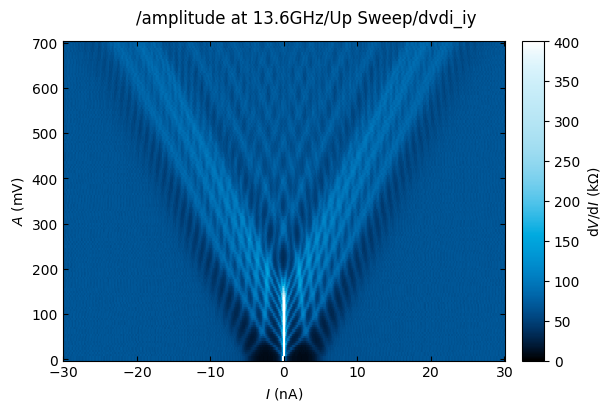

In [6]:
# plot and load exp data
%matplotlib inline
from utilities.ivplot import IVPlot
importlib.reload(sys.modules["utilities.ivplot"])
logger = logging.getLogger()
logger.setLevel(level=logging.WARNING)

eva = IVPlot()
eva.title = f"amplitude at {nu_GHz:.1f}GHz"
eva.sub_folder = ""
eva.loadData()
eva.to_plot = eva.up_sweep
eva.title_of_plot = "Up Sweep"
eva.y_characters = [r"$A$", "V"]
eva.dvdi_norm = (1e3, 'k')
eva.didv_c_lim = (0, 0.4)
eva.dvdi_c_lim = (0, 0.4e6)
if window[1] >2:
    eva.smoothing = True
    eva.window_length = window[1]
else:
    eva.smoothing = False
eva.plot_T = False
eva.plot_dvdis = True
eva.plot_didvs = True
eva.plot_all()

In [7]:
# region offset definitions
import jax
import jax.numpy as jnp


def bin_y_over_x_jax(x, y, x_bins):
    """
    1D binning with JAX-safe scatter (no boolean indexing).
    """
    edges = (x_bins[:-1] + x_bins[1:]) / 2
    edges = jnp.concatenate(
        [
            jnp.array([x_bins[0] - (edges[0] - x_bins[0])]),
            edges,
            jnp.array([x_bins[-1] + (x_bins[-1] - edges[-1])]),
        ]
    )

    idx = jnp.digitize(x, edges) - 1  # shape (N,)

    # Clip indices to [0, M-1], out-of-range will produce 0 in sum but count will be 0
    idx_clipped = jnp.clip(idx, 0, x_bins.shape[0] - 1)
    mask = (idx >= 0) & (idx < x_bins.shape[0])
    mask = mask.astype(x.dtype)

    # Sum and count using scatter_add
    sum_y = jnp.zeros(x_bins.shape[0], dtype=y.dtype)
    count = jnp.zeros(x_bins.shape[0], dtype=y.dtype)

    sum_y = sum_y.at[idx_clipped].add(y * mask)
    count = count.at[idx_clipped].add(mask)

    return jnp.where(count > 0, sum_y / count, jnp.nan)


# vectorized over offsets
def bin_y_over_x_offsets(x, y, x_bins, x_off):
    """
    Bin I-V curves shifted by multiple offsets in one call.

    Parameters
    ----------
    x : (N,) x-values
    y : (N,) y_values
    x_bins : (M,) bin centers
    x_off : (K,) offsets

    Returns
    -------
    binned : (M, K) binned currents per offset
    """

    # Define a function for a single offset
    def single_offset_bin(x_shift):
        return bin_y_over_x_jax(x - x_shift, y, x_bins)

    # vmap over all offsets
    binned = jax.vmap(single_offset_bin)(x_off)  # shape (K, M)

    return binned.T  # return shape (M, K)


# endregion

  0%|          | 0/141 [00:00<?, ?it/s]/var/folders/kc/8fnzl3f94vxgl8w4wm3wfvk80000gn/T/ipykernel_4118/4210429596.py:27: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  sum_y = jnp.zeros(x_bins.shape[0], dtype=y.dtype)
/var/folders/kc/8fnzl3f94vxgl8w4wm3wfvk80000gn/T/ipykernel_4118/4210429596.py:28: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  count = jnp.zeros(x_bins.shape[0], dtype=y.dtype)
100%|██████████| 141/141 [01:14<00:00,  1.91it/s]


Text(0.5, 0.98, 'Offsets and Errors')

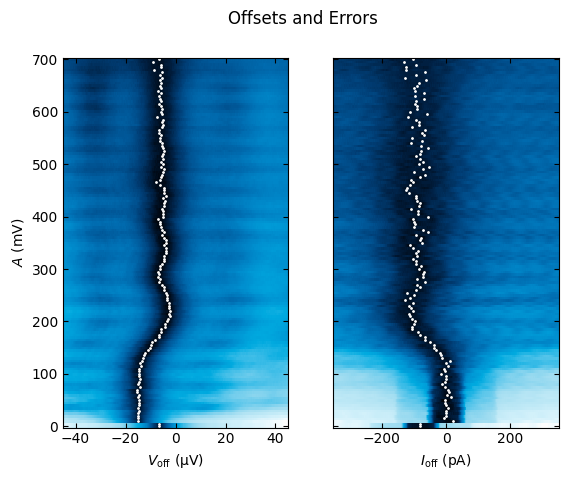

In [8]:
# region initialization
eva = IVEvaluation()
eva.title = f"amplitude at {nu_GHz:.1f}GHz"
eva.sub_folder = ""
eva.loadData()

dV_off_mV = V_off_range_mV[1] - V_off_range_mV[0]
dI_off_nA = I_off_range_nA[1] - I_off_range_nA[0]

A_mV: NDArray[np.float64] = np.array(eva.mapped["y_axis"], dtype="float64") * 1e3
dA_mV = A_mV[1] - A_mV[0]
T_exp_K: NDArray[np.float64] = np.array(eva.up_sweep["temperature"], dtype="float64")

V_err_mV = np.full((A_mV.shape[0], V_off_range_mV.shape[0]), np.nan, dtype="float64")
I_err_nA = np.full((A_mV.shape[0], I_off_range_nA.shape[0]), np.nan, dtype="float64")

V_off_mV = np.full((A_mV.shape[0]), np.nan, dtype="float64")
I_off_nA = np.full((A_mV.shape[0]), np.nan, dtype="float64")

I_exp_nA = np.full((A_mV.shape[0], V_mV.shape[0]), np.nan, dtype="float64")
G_exp_G0 = np.full((A_mV.shape[0], V_mV.shape[0]), np.nan, dtype="float64")
V_exp_mV = np.full((A_mV.shape[0], I_nA.shape[0]), np.nan, dtype="float64")
R_exp_Ohm = np.full((A_mV.shape[0], I_nA.shape[0]), np.nan, dtype="float64")
# endregion

# region big loop
for j_a, a_mV in enumerate(tqdm(A_mV)):

    v, i = eva.up_sweep["iv_tuples"][j_a][0:2]
    v_mV = np.array(v, dtype="float64") * 1e3
    i_nA = np.array(i, dtype="float64") * 1e9

    v_mV, i_nA = oversample(v_mV, i_nA, upsample=10)

    i_tmp = bin_y_over_x_offsets(v_mV, i_nA, V_mV, V_off_range_mV)
    g_tmp = np.gradient(i_tmp, V_mV, axis=0)
    g_err = np.mean(np.abs(g_tmp - np.flip(g_tmp, axis=0)), axis=0)
    v_off = V_off_range_mV[np.argmin(g_err)]

    v_tmp = bin_y_over_x_offsets(i_nA, v_mV, I_nA, I_off_range_nA)
    r_tmp = np.gradient(v_tmp, I_nA, axis=0)
    r_err = np.mean(np.abs(r_tmp - np.flip(r_tmp, axis=0)), axis=0)
    i_off = I_off_range_nA[np.argmin(r_err)]

    i_exp = bin_y_over_x(v_mV - v_off, i_nA - i_off, V_mV)
    g_exp = np.gradient(i_exp, V_mV) / G_0_muS

    v_exp = bin_y_over_x(i_nA - i_off, v_mV - v_off, I_nA)
    r_exp = np.gradient(v_exp, I_nA) * 1e6

    V_err_mV[j_a, :] = g_err
    I_err_nA[j_a, :] = r_err

    V_off_mV[j_a] = v_off
    I_off_nA[j_a] = i_off

    I_exp_nA[j_a, :] = i_exp
    G_exp_G0[j_a, :] = g_exp
    V_exp_mV[j_a, :] = v_exp
    R_exp_Ohm[j_a, :] = r_exp
# endregion

# region relocalization
eva.mapped["voltage_axis"] = V_mV * 1e-3
eva.mapped["current_axis"] = I_nA * 1e-9
eva.up_sweep["current"] = I_exp_nA * 1e-9
eva.up_sweep["differential_conductance"] = G_exp_G0
eva.up_sweep["voltage"] = V_exp_mV * 1e-3
eva.up_sweep["differential_resistance"] = R_exp_Ohm
eva.up_sweep["V_err_mV"] = V_err_mV * 1e-3
eva.up_sweep["I_err_nA"] = I_err_nA * 1e-9
eva.up_sweep["V_off_mV"] = V_off_mV * 1e-3
eva.up_sweep["I_off_nA"] = I_off_nA * 1e-9


eva.title = f"amplitude at {nu_GHz:.1f}GHz offset_correction"
eva.saveData()
# endregion

# region plot offset errors
fig, [ax_i, ax_v] = plt.subplots(1, 2, num=0, sharey=True)

ax_i.imshow(
    V_err_mV,
    cmap=cmap(),
    aspect="auto",
    origin="lower",
    interpolation="none",
    extent=(
        (V_off_range_mV[0] - dV_off_mV / 2) * 1e3,
        (V_off_range_mV[-1] + dV_off_mV / 2) * 1e3,
        A_mV[0] - dA_mV / 2,
        A_mV[-1] + dA_mV / 2,
    ),
)
ax_i.plot(V_off_mV * 1e3, A_mV, ".", color="w", ms=2)

ax_v.imshow(
    I_err_nA,
    cmap=cmap(),
    aspect="auto",
    origin="lower",
    interpolation="none",
    extent=(
        (I_off_range_nA[0] - dI_off_nA / 2) * 1e3,
        (I_off_range_nA[-1] + dI_off_nA / 2) * 1e3,
        A_mV[0] - dA_mV / 2,
        A_mV[-1] + dA_mV / 2,
    ),
)
ax_v.plot(I_off_nA * 1e3, A_mV, ".", color="w", ms=2)

ax_i.set_ylabel("$A$ (mV)")
ax_i.set_xlabel("$V_\\mathrm{off}$ (µV)")
ax_v.set_xlabel("$I_\\mathrm{off}$ (pA)")


for ax in [ax_i, ax_v]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=True,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )
fig.suptitle("Offsets and Errors")
# endregion

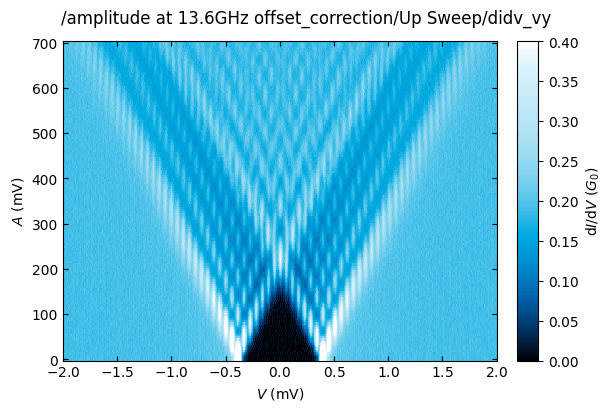

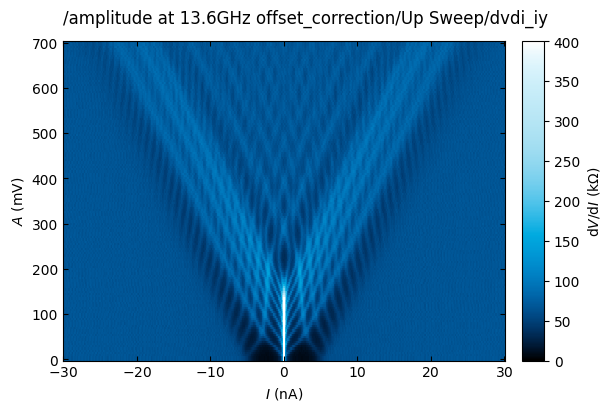

In [11]:
# plot and load offset_corrected data
%matplotlib inline
from utilities.ivplot import IVPlot
importlib.reload(sys.modules["utilities.ivplot"])
logger = logging.getLogger()
logger.setLevel(level=logging.WARNING)

eva = IVPlot()
eva.title = f"amplitude at {nu_GHz:.1f}GHz offset_correction"
eva.sub_folder = ""
eva.loadData()

eva.to_plot = eva.up_sweep
eva.title_of_plot = "Up Sweep"
eva.y_characters = [r"$A$", "V"]
eva.dvdi_norm = (1e3, 'k')
eva.didv_c_lim = (0, 0.4)
eva.dvdi_c_lim = (0, 0.4e6)
if window[1] >2:
    eva.smoothing = True
    eva.window_length = window[1]
else:
    eva.smoothing = False
eva.plot_T = False
eva.plot_dvdis = True
eva.plot_didvs = True
eva.plot_all()

In [13]:
%matplotlib qt

In [45]:
%matplotlib inline

# Model: 'dynes'
# Optimizer: 'curve_fit'

# --- paramters ---
# τ = 0.1887564289885446 (0.00036309986916895195)
# T = 178.5898214044085 (11.066382781372708) mK
# Δ = 194.84118653195813 (0.46966769765339195) µeV
# Γ = 3.7505931915972432 (0.5709854750147855) µeV

# --- input ---
# solution = fit_current(
#     V_mV=V_mV,
#     I_nA=I_nA,
#     tau=(0.18904023, (0.1, 0.3), False),
#     T_K=(0.23662111, (0.0, 2.0), False),
#     Delta_mV=(0.1933102, (0.19, 0.2), False),
#     Gamma_mV=(0.00063074, (0.0001, 0.03), False),
#     A_mV=(0.1, (0.0, 0.3), False),
#     nu_GHz=(18.3, (18.2, 18.4), True),
#     model="dynes",
#     optimizer="curve_fit",
# )


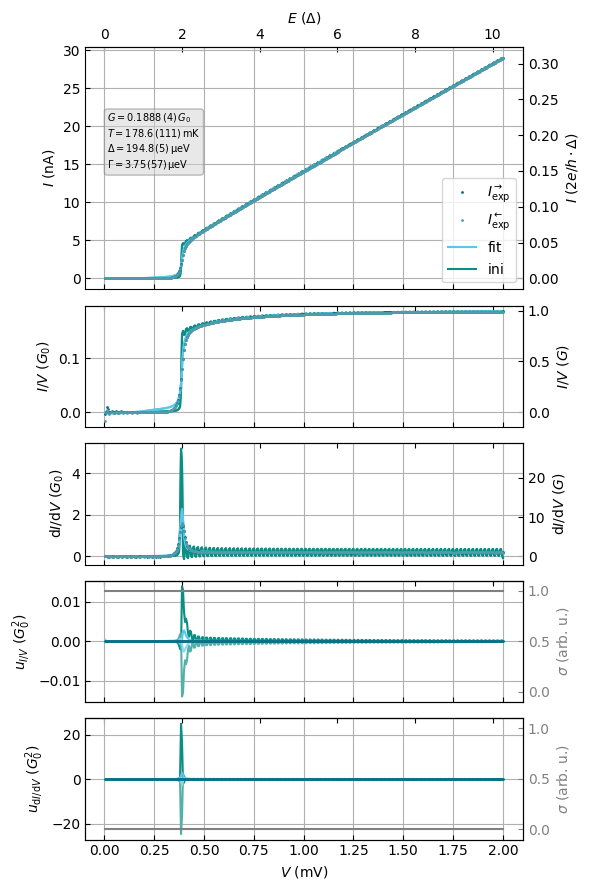

In [ ]:
from theory.optimizers.fit_current import fit_current
from theory.optimizers.show_fitting import show_fitting, show_stats

importlib.reload(sys.modules["theory.optimizers.fit_current"])
importlib.reload(sys.modules["theory.optimizers.show_fitting"])

solution = fit_current(
    V_mV=V_mV,
    I_nA=I_exp_nA[0, :],
    tau=(0.18904023, (0.1, 0.3), False),
    T_K=(0.23662111, (0, 2), False),
    Delta_mV=(0.1933102, (0.190, 0.2), False),
    Gamma_mV=(0.00063074, (1e-4, 30e-3), False),
    A_mV=(0.1, (0, 0.3), False),
    nu_GHz=(18.3, (18.2, 18.4), True),
    model="dynes+pat",
    optimizer="curve_fit",
)
show_stats(solution)
show_fitting(solution)

In [ ]:
# calculate I_dynes
from theory.models.models import get_I_nA

importlib.reload(sys.modules["theory.models.models"])
I_dynes_raw_nA = get_I_nA(
    V_mV=V_raw_mV,
    tau=tau_0_arbu,
    T_K=T_exp_K * 2.5,
    Delta_meV=Delta_0_meV,
    Gamma_meV=Gamma_0_meV,
    model="dynes",
)

Dynes:   0%|          | 0/142 [00:00<?, ?it/s]

In [36]:
# import theory stuff
importlib.reload(sys.modules["theory.models.PAT"])

from theory.models.PAT import get_I_pat_nA

I_pat_raw_nA = get_I_pat_nA(
    A_mV=A_mV * 1e-3 * 2,
    V_mV=V_raw_mV,
    I_nA=I_dynes_raw_nA,
    nu_GHz=nu_GHz,
    N=N,
)

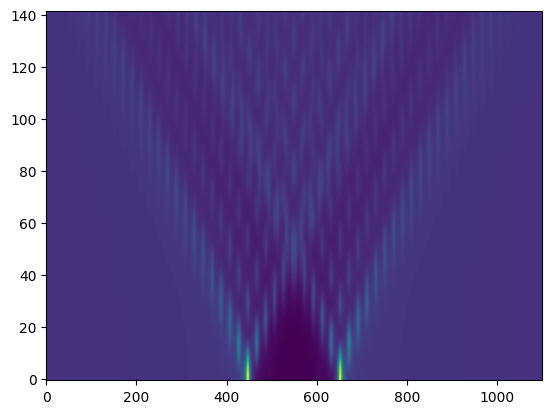

In [37]:
plt.imshow(np.gradient(I_pat_raw_nA, V_raw_mV, axis=1), aspect="auto", origin="lower")

In [ ]:
from theory.optimizers.fit_current import fit_dynes
from theory.optimizers.show_fitting import show_fit_dynes

importlib.reload(sys.modules["theory.optimizers.curve_fit_dynes"])
importlib.reload(sys.modules["theory.optimizers.show_curve_fit_dynes"])

solution = fit_dynes(
    V_mV=V_raw_mV,
    I_nA=I_exp_raw_nA[0, :],
    tau=(0.189, (0.1, 0.3), None),
    T_K=(0.234, (0.1, 2.0), False),
    Delta_mV=(0.196, (0.190, 0.2), True),
    Gamma_mV=(6e-3, (1e-3, 25e-3), False),
)
show_fit_dynes(solution)

ModuleNotFoundError: No module named 'theory'

In [ ]:
I_0_exp_raw_nA = I_exp_raw_nA[0, :]
plt.plot(V_raw_mV, I_0_exp_raw_nA)
plt.plot(V_raw_mV, V_raw_mV * 0.189 * G_0_muS)

In [ ]:
x = V_raw_mV
y = I_0_exp_raw_nA / G_0_muS
w = np.ones_like(x)
w[np.abs(x) < 3 * Delta_0_meV] = 0
a, b = np.polyfit(
    x=x,
    y=y,
    deg=1,
    w=w,
)

In [ ]:
plt.plot(x, y)
plt.plot(x, a * x + b)

In [ ]:
def fit_b_fixed_slope(x, y, a, vcut):
    # mask points far outside gap
    mask = np.abs(x) > vcut
    x_sel = x[mask]
    y_sel = y[mask]
    if x_sel.size == 0:
        raise ValueError("No points outside vcut")

    r = y_sel - a * x_sel  # residuals = b + noise
    b = r.mean()
    return b


b = fit_b_fixed_slope(x, y, a=tau_0_arbu, vcut=3 * Delta_0_meV)
b

np.float64(0.0004057197937035629)

In [ ]:
plt.plot(x, y)
plt.plot(-x, -y)
plt.plot(x, tau_0_arbu * x + b)
plt.plot(x, y + b)
plt.plot(-x, -(y + b))

In [ ]:
# plot map comparison sim/exp
I_theo_nA = I_nA_dynes
G_theo = G_dynes
y = T_K


def VtoE(V_mV):
    return V_mV / Delta_meV


def EtoV(E_meV):
    return E_meV * Delta_meV


V_label = r"$V_0$ (mV)"
E_label = r"$eV_0$ ($\Delta$)"
I_label = r"$I$ (nA)"
G_label = r"d$I/$d$V$ ($G_0$)"
y_label = r"$T$ (K)"

img_z = np.concatenate((np.flip(G_dynes[:, 1:], axis=1), G_exp), axis=1)
img_x = np.concatenate((-np.flip(V_mV[1:]), V_mV), axis=0)
img_y = y

dx, dy = img_x[-1] - img_x[-2], img_y[-1] - img_y[-2]
ext = (img_x[0] - dx / 2, img_x[-1] + dx / 2, img_y[0] - dy / 2, img_y[-1] + dy / 2)
clim = (
    np.nanmean(img_z) - 2 * np.nanstd(img_z),
    np.nanmean(img_z) + 2 * np.nanstd(img_z),
)
clim = (0, 1)

T_indices = []
for T_in in T_interest:
    T_indices.append(np.argmin(np.abs(y - T_in)))

# fig and axs
fig, axs = plt.subplots(
    figsize=(8, 4),
    nrows=3,
    ncols=2,
    height_ratios=(0.2, 1.8, 1),
    # sharex = True
)
plt.subplots_adjust(hspace=0.1, wspace=0.05)
ax_clb = axs[0, 0]

gs = axs[0, 1].get_gridspec()
for ax in axs[1:, 0]:
    ax.remove()
ax_img = fig.add_subplot(gs[1:, 0])

gs = axs[1, 0].get_gridspec()
for ax in axs[:2, 1]:
    ax.remove()
ax_i = fig.add_subplot(gs[:2, 1])

ax_g = axs[2, 1]

for ax in [ax_clb, ax_img, ax_i, ax_g]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=False,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )


im = ax_img.imshow(
    img_z,
    aspect="auto",
    origin="lower",
    clim=clim,
    extent=ext,
    interpolation=None,
    cmap=cmap(bad="grey"),
)
ax_img.vlines(0, ymin=ext[2], ymax=ext[3], color="k")
ax_img.plot(+2 * Delta_T_meV, T_K, "--", color="grey", alpha=0.5)
ax_img.plot(-2 * Delta_T_meV, T_K, "--", color="grey", alpha=0.5)

cbar = fig.colorbar(
    im,
    cax=ax_clb,
    label=G_label,
    orientation="horizontal",
    location="top",
)

ax_img_xlim = ax_img.get_xlim()
for i, T_i in enumerate(T_indices):
    color = colors[i]
    ax_i.plot(V_mV, I_exp_nA[T_i, :], ".", ms=1, color=color)
    ax_i.plot(V_mV, I_theo_nA[T_i, :], "-", color=color)
    ax_g.plot(V_mV, G_exp[T_i, :], ".", ms=1, color=color)
    ax_g.plot(V_mV, G_theo[T_i, :], "-", color=color)
    ax_img.plot(ax_img_xlim, (T_interest[i], T_interest[i]), alpha=0.5, color=color)

ax_i_2 = ax_i.secondary_xaxis("top", functions=(VtoE, EtoV))
ax_i_2.tick_params(direction="in", top=True)
ax_g_2 = ax_g.secondary_xaxis("top", functions=(VtoE, EtoV))
ax_g_2.tick_params(direction="in", top=True)

ax_i.xaxis.set_ticklabels([])
ax_g_2.xaxis.set_ticklabels([])

ax_g.yaxis.set_label_position("right")
ax_g.yaxis.tick_right()

ax_i.yaxis.set_label_position("right")
ax_i.yaxis.tick_right()

ax_img.set_ylabel(y_label)
ax_img.set_xlabel(V_label)
ax_g.set_xlabel(V_label)
ax_g.set_ylabel(G_label)
ax_i_2.set_xlabel(E_label)
ax_i.set_ylabel(I_label)

# add text box for the statistics
stats = (
    f"$G={tau:.4f}\\,G_0$\n"
    f"$\\Delta={Delta_meV*1e3:.1f}\\,$µeV\n"
    f"$\\Gamma={Gamma_meV*1e3:.1f}\\,$µeV"
)
bbox = dict(boxstyle="round", fc="lightgrey", ec="grey", alpha=0.5)
ax_i.text(
    0.05,
    0.7,
    stats,
    fontsize=9,
    bbox=bbox,
    transform=ax_i.transAxes,
    horizontalalignment="left",
)

ax_img.text(0.05, 0.9, "sim", fontsize=9, bbox=bbox, transform=ax_img.transAxes)
ax_img.text(0.85, 0.9, "exp", fontsize=9, bbox=bbox, transform=ax_img.transAxes)

plt.savefig("over_temperature.png")

In [ ]:
# fit parameter
I_0_exp_nA = I_exp_nA[1, :]

p0 = np.array(
    [
        0.18861238619219342,
        0.33346012175065864,
        0.1954362246372233,
        0.0073389200475204005,
    ]
)
bounds = (
    np.array([0.18861, 0.20, 190e-3, 5e-3]),
    np.array([0.18862, 0.35, 200e-3, 25e-3]),
)
maxfev = 10000

In [ ]:
# jax curve fit optimizer for I_0_exp
%reload_ext autoreload
%autoreload 2

import jax.numpy as jnp
from jax import jit, vmap, Array
from jaxfit import CurveFit

from theory.models.dynes_jnp import current, thermal_energy_gap

importlib.reload(sys.modules["theory.models.dynes_jnp"])

G_0_muS_jax = jnp.array(G_0_muS)

@jit
def get_I_nA_optimize(
    V_mV: Array,
    T_K: float,
    Delta_meV: float,
    Gamma_meV: float,
) -> NDArray:
    E_meV: Array = jnp.linspace(-2, 2, 2001)
    current_vectorized = vmap(
        lambda V_mV: current(
            V_meV=V_mV,
            E_meV=E_meV,
            Delta_1_meV=Delta_meV,
            Delta_2_meV=Delta_meV,
            T_K=T_K,
            Gamma_1_meV=Gamma_meV,
            Gamma_2_meV=Gamma_meV,
        ),
        in_axes=0,
    )
    I_nA = current_vectorized(V_mV) * G_0_muS_jax
    return I_nA


def get_I_nA_srapper(x: NDArray, tau:float, T_K:float, Delta_meV:float, Gamma_meV:float) -> NDArray:
    Delta_meV = thermal_energy_gap(Delta_meV=Delta_meV, T_K=T_K)
    I_nA = get_I_nA_optimize(
        V_mV=jnp.array(x, dtype='float64'),
        T_K=T_K,
        Delta_meV=Delta_meV,
        Gamma_meV=Gamma_meV,
    )
    return I_nA * tau

jcf = CurveFit()

popt, pcov = jcf.curve_fit(
    f=get_I_nA_srapper, 
    xdata=np.array(V_mV, dtype='float64'),
    ydata=np.array(I_0_exp_nA, dtype='float64'),
    absolute_sigma=True,
    p0 = p0,
    bounds=bounds,
    maxfev=maxfev,
    )
perr = np.sqrt(np.diag(pcov))

I_theo = get_I_nA_srapper(V_mV, *popt)
I_init = get_I_nA_srapper(V_mV, *p0)

print(f'tau = {popt[0]:.5f} ({int(perr[0]*1e5)})')
print(f'T = {popt[1]*1e3:.1f} ({int(perr[1]*1e4)}) mK')
print(f'Delta = {popt[2]*1e3:.2f} ({int(perr[2]*1e5)}) µeV')
print(f'Gamma = {popt[3]*1e3:.2f} ({int(perr[3]*1e5)}) µeV')

tau = 0.18861 (234)
T = 266.5 (8742) mK
Delta = 194.75 (608) µeV
Gamma = 8.17 (173) µeV


In [ ]:
# get possibilities within bounds
bounds_array = np.array(bounds).T

# Sample n values per parameter
n = 4
param_grid = [np.linspace(lo, hi, n) for lo, hi in bounds_array]

# All combinations
param_sets = list(product(*param_grid))  # shape: (n^4, 4)

I_bounds = np.array([get_I_nA_srapper(V_mV, *params) for params in param_sets])
G_bounds = np.gradient(I_bounds, V_mV, axis=1) / G_0_muS

In [ ]:
# get possibilities within errors
error_array = np.array([popt - perr, popt + perr]).T

# Sample n values per parameter
n = 4
param_grid = [np.linspace(lo, hi, n) for lo, hi in error_array]

# All combinations
param_sets = list(product(*param_grid))  # shape: (n^4, 4)

I_error = np.array([get_I_nA_srapper(V_mV, *params) for params in param_sets])
G_error = np.gradient(I_error, V_mV, axis=1) / G_0_muS

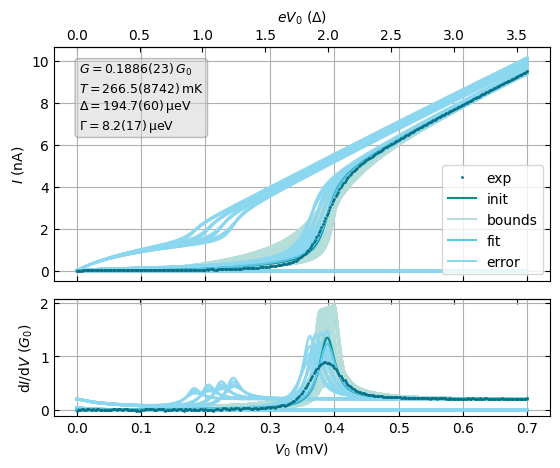

In [ ]:
# show fitting procedure
%matplotlib inline

fig, (ax_i, ax_g) = plt.subplots(ncols=1, nrows=2, sharex=True, height_ratios=(2,1))
plt.subplots_adjust(hspace=0.1, wspace=0.05)

ax_i.plot(V_mV, I_0_exp_nA, '.', label='exp', color=colors[3], ms=2, zorder=13)
ax_g.plot(V_mV, np.gradient(I_0_exp_nA, V_mV)/G_0_muS, '.', color=colors[3], ms=2, zorder=13)

ax_i.plot(V_mV, I_init, label='init', color=colors[4], zorder=11)
ax_g.plot(V_mV, np.gradient(I_init, V_mV)/G_0_muS, color=colors[4], zorder=11)
ax_i.plot(V_mV, I_bounds[0,:], color=lighten_color(colors[4], .7), label='bounds')
for i in range(np.shape(I_bounds)[0]):
    ax_i.plot(V_mV, I_bounds[i,:], color=lighten_color(colors[4], .7))
    ax_g.plot(V_mV, G_bounds[i,:], color=lighten_color(colors[4], .7))

ax_i.plot(V_mV, I_theo, label='fit', color=colors[0], zorder=12)
ax_g.plot(V_mV, np.gradient(I_theo, V_mV)/G_0_muS, color=colors[0], zorder=12)
ax_i.plot(V_mV, I_error[0,:], color=lighten_color(colors[0], .3), label='error')
for i in range(np.shape(I_error)[0]):
    ax_i.plot(V_mV, I_error[i,:], color=lighten_color(colors[0], .3), alpha=.5)
    ax_g.plot(V_mV, G_error[i,:], color=lighten_color(colors[0], .3), alpha=.5)

ax_i.legend(loc='lower right')


for ax in [ax_i, ax_g]:
    ax.tick_params(
            direction='in',       # Ticks nach innen
            top=False,             # obere Ticks ein
            bottom=True,          # untere Ticks ein
            left=True,            # linke Ticks ein
            right=True,           # rechte Ticks ein
            which='both'          # sowohl Major- als auch Minor-Ticks
        )
    ax.grid()

def VtoE(V_mV):
    return V_mV/Delta_meV
def EtoV(E_meV):
    return E_meV*Delta_meV
ax_i_2 = ax_i.secondary_xaxis("top", functions=(VtoE, EtoV))
ax_i_2.tick_params(direction='in', top=True)
ax_g_2 = ax_g.secondary_xaxis("top", functions=(VtoE, EtoV))
ax_g_2.tick_params(direction='in', top=True)

ax_g_2.xaxis.set_ticklabels([])

ax_g.set_xlabel(V_label)
ax_g.set_ylabel(G_label)
ax_i_2.set_xlabel(E_label)
ax_i.set_ylabel(I_label)

# add text box for the statistics
stats = (f'$G={popt[0]:.4f} ({int(perr[0]*1e4)})\\,G_0$\n'
         f'$T={popt[1]*1e3:.1f} ({int(perr[1]*1e4)})\\,$mK\n'
        f'$\\Delta={popt[2]*1e3:.1f} ({int(perr[2]*1e4)})\\,$µeV\n'
        f'$\\Gamma={popt[3]*1e3:.1f} ({int(perr[3]*1e4)})\\,$µeV')
bbox = dict(boxstyle='round', fc='lightgrey', ec='grey', alpha=0.5)
ax_i.text(0.05, .65, stats, fontsize=9, bbox=bbox,
        transform=ax_i.transAxes, horizontalalignment='left')
fig.savefig('fitting_procedure.png')

In [ ]:
# jax curve fit over I over T_K
%reload_ext autoreload
%autoreload 2


def fixed_I_nA(x: NDArray, T_K:float):
    tau = 0.18835012
    Delta_meV = 0.19524671
    Gamma_meV = 0.00823909
    return get_I_nA_srapper(x, tau, T_K, Delta_meV, Gamma_meV)

jcf = CurveFit()

T_fit_K = np.zeros_like(T_K)
dT_fit_K = np.zeros_like(T_K)
for i, I_0_nA in enumerate(tqdm(I_exp_nA)):
    popt, pcov = jcf.curve_fit(
        f=fixed_I_nA, 
        xdata=np.array(V_mV, dtype='float64'),
        ydata=np.array(I_0_nA, dtype='float64'),
        p0 = T_K[i],
        )
    T_fit_K[i] = popt[0]
    
    perr = np.sqrt(np.diag(pcov))
    dT_fit_K[i] = perr[0]

100%|██████████| 241/241 [01:03<00:00,  3.82it/s]


In [ ]:
# calibrate T_K with curve_fit
T_theo_K = np.copy(T_fit_K)

T_exp_K = T_K[T_theo_K <= 2]
T_theo_K = T_theo_K[T_theo_K <= 2]


def calibration_T(T: NDArray, T_base: float, T_off: float, alpha: float):
    T = T_off + alpha * T
    return np.where(T <= T_base, T_base, T)


T_popt, T_pcov = curve_fit(
    f=calibration_T,
    xdata=np.array(T_exp_K, dtype="float64"),
    ydata=np.array(T_theo_K, dtype="float64"),
)
T_perr = np.sqrt(np.diag(T_pcov))
T_cal_K = calibration_T(T_exp_K, T_popt[0], T_popt[1], T_popt[2])
T_popt, T_perr

print(f"T_base = {T_popt[0]*1e3:.1f} ({int(T_perr[0]*1e4)}) mK")
print(f"T_off = {T_popt[1]*1e3:.1f} ({int(T_perr[1]*1e4)}) mK")
print(f"alpha = {T_popt[2]:.5f} ({int(T_perr[2]*1e5)})")

T_base = 311.0 (13) mK
T_off = -92.2 (21) mK
alpha = 1.01297 (242)


In [ ]:
# get possibilities within errors
T_error_array = np.array([T_popt - T_perr, T_popt + T_perr]).T

# Sample n values per parameter
n = 4
param_grid = [np.linspace(lo, hi, n) for lo, hi in T_error_array]

# All combinations
param_sets = list(product(*param_grid))  # shape: (n^4, 4)

T_err_K = np.array([calibration_T(T_exp_K, *params) for params in param_sets])

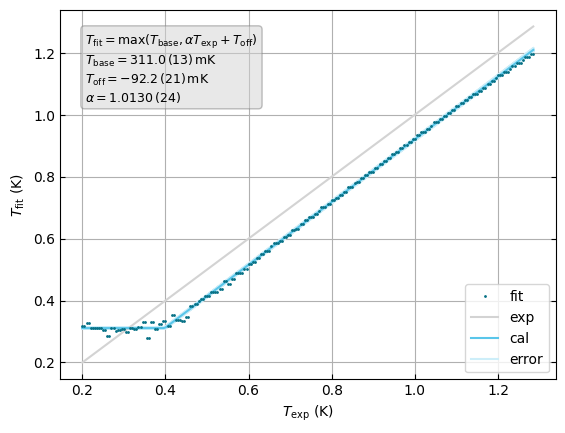

In [ ]:
# show calibration procedure
%matplotlib inline

fig, (ax_T) = plt.subplots()

ax_T.plot(T_exp_K, T_theo_K, '.', label='fit', color=colors[3], ms=2, zorder=13)
ax_T.plot(T_exp_K, T_exp_K, label='exp', color='lightgrey', zorder=11)
ax_T.plot(T_exp_K, T_cal_K, label="cal", color=colors[0], zorder=12)
ax_T.plot(T_exp_K, T_err_K[0,:], color=lighten_color(colors[0], .7), label="error", zorder=10)
ax_T.plot(T_exp_K, T_err_K.T, color=lighten_color(colors[0], .7), zorder=10)

ax_T.tick_params(
        direction='in',       # Ticks nach innen
        top=False,             # obere Ticks ein
        bottom=True,          # untere Ticks ein
        left=True,            # linke Ticks ein
        right=True,           # rechte Ticks ein
        which='both'          # sowohl Major- als auch Minor-Ticks
    )

ax_T.grid()
ax_T.legend()
ax_T.set_xlabel('$T_\\mathrm{exp}$ (K)')
ax_T.set_ylabel('$T_\\mathrm{fit}$ (K)')


# add text box for the statistics
stats = ('$T_\\mathrm{fit} = \\mathrm{max}(T_\\mathrm{base}, \\alpha T_\\mathrm{exp}+T_\\mathrm{off})$ \n'
    '$T_\\mathrm{base}$'
    f'$={T_popt[0]*1e3:.1f}\\,({int(T_perr[0]*1e4)})\\,$mK\n'
         '$T_\\mathrm{off} = $'
         f'${T_popt[1]*1e3:.1f}\\,({int(T_perr[1]*1e4)})\\,$mK\n'
        f'$\\alpha={T_popt[2]:.4f}\\,({int(T_perr[2]*1e4)})\\,$')
bbox = dict(boxstyle='round', fc='lightgrey', ec='grey', alpha=0.5)
ax_T.text(0.05, .75, stats, fontsize=9, bbox=bbox,
        transform=ax_T.transAxes, horizontalalignment='left')
plt.savefig('temperature_model.png')

In [ ]:
# calibration data
T_base: float = 0.25828968
T_off: float = -0.12844258
alpha: float = 1.04900186

# fit parameter
tau: float = 0.18835012
Delta_meV: float = 0.19524671
Gamma_meV: float = 0.00823908

In [ ]:
# # plot comparison (sim input is T_fit)
# I_nA_dynes = get_I_nA(
#     V_mV = V_mV,
#     tau=tau,
#     T_K=T_fit_K,
#     Delta_meV=Delta_meV,
#     Gamma_meV=Gamma_meV,
#     model='dynes',
#     )
# G_dynes = np.gradient(I_nA_dynes, V_mV, axis=-1) / G_0_muS

# V_mV = V_mV
# Delta_meV = Delta_meV
# I_exp_nA = I_exp_nA
# G_exp = G_exp
# I_theo_nA = I_nA_dynes
# G_theo = G_dynes
# y = T_K

# # plot map comparison sim/exp

# def VtoE(V_mV): return V_mV / Delta_meV
# def EtoV(E_meV): return E_meV * Delta_meV

# V_label=r'$V_0$ (mV)'
# E_label=r'$eV_0$ ($\Delta$)'
# I_label=r'$I$ (nA)'
# G_label=r'd$I/$d$V$ ($G_0$)'
# y_label=r'$T^*$ (K)'

# img_z = np.concatenate((np.flip(G_dynes[:,1:], axis=1), G_exp), axis=1)
# img_x = np.concatenate((-np.flip(V_mV[1:]), V_mV), axis=0)
# img_y = y

# dx, dy = img_x[-1]-img_x[-2], img_y[-1]-img_y[-2]
# ext = (img_x[0]-dx/2, img_x[-1]+dx/2, img_y[0]-dy/2, img_y[-1]+dy/2)
# clim = (np.nanmean(img_z)-2*np.nanstd(img_z), np.nanmean(img_z)+2*np.nanstd(img_z))
# clim = (0, 1)

# T_indices = []
# for T_in in T_interest:
#     T_indices.append(np.argmin(np.abs(y-T_in)))

# # fig and axs
# fig, axs = plt.subplots(
#     figsize=(8,4),
#     nrows=3,
#     ncols=2,
#     height_ratios=(0.2, 1.8, 1),
#     # sharex = True
#     )
# plt.subplots_adjust(hspace=0.1, wspace=0.05)
# ax_clb = axs[0,0]

# gs = axs[0, 1].get_gridspec()
# for ax in axs[1:, 0]:
#     ax.remove()
# ax_img = fig.add_subplot(gs[1:, 0])

# gs = axs[1,0].get_gridspec()
# for ax in axs[:2, 1]:
#     ax.remove()
# ax_i = fig.add_subplot(gs[:2, 1])

# ax_g = axs[2,1]

# for ax in [ax_clb,ax_img, ax_i, ax_g]:
#     ax.tick_params(
#             direction='in',       # Ticks nach innen
#             top=False,             # obere Ticks ein
#             bottom=True,          # untere Ticks ein
#             left=True,            # linke Ticks ein
#             right=True,           # rechte Ticks ein
#             which='both'          # sowohl Major- als auch Minor-Ticks
#         )


# im = ax_img.imshow(
#     img_z,
#     aspect='auto',
#     origin='lower',
#     clim=clim,
#     extent=ext,
#     interpolation=None,
#     cmap=cmap(bad="grey"),
#     )
# ax_img.vlines(0, ymin=ext[2], ymax=ext[3], color='k')

# cbar = fig.colorbar(
#     im,
#     cax=ax_clb,
#     label=G_label,
#     orientation='horizontal',
#     location='top',
#     )

# ax_img_xlim = ax_img.get_xlim()
# for i, T_i in enumerate(T_indices):
#     color=colors[i]
#     ax_i.plot(V_mV, I_exp_nA[T_i,:], '.', ms=1, color=color)
#     ax_i.plot(V_mV, I_theo_nA[T_i,:], '-', color=color)
#     ax_g.plot(V_mV, G_exp[T_i,:], '.', ms=1, color=color)
#     ax_g.plot(V_mV, G_theo[T_i,:], '-', color=color)
#     ax_img.plot(ax_img_xlim, (T_interest[i], T_interest[i]), alpha=.5, color=color)

# ax_i_2 = ax_i.secondary_xaxis("top", functions=(VtoE, EtoV))
# ax_i_2.tick_params(direction='in', top=True)
# ax_g_2 = ax_g.secondary_xaxis("top", functions=(VtoE, EtoV))
# ax_g_2.tick_params(direction='in', top=True)

# ax_i.xaxis.set_ticklabels([])
# ax_g_2.xaxis.set_ticklabels([])

# ax_g.yaxis.set_label_position("right")
# ax_g.yaxis.tick_right()

# ax_i.yaxis.set_label_position("right")
# ax_i.yaxis.tick_right()

# ax_img.set_ylabel(y_label)
# ax_img.set_xlabel(V_label)
# ax_g.set_xlabel(V_label)
# ax_g.set_ylabel(G_label)
# ax_i_2.set_xlabel(E_label)
# ax_i.set_ylabel(I_label)

# # add text box for the statistics
# stats = (f'$G={tau:.4f}\\,G_0$\n'
#         f'$\\Delta={Delta_meV*1e3:.1f}\\,$µeV\n'
#         f'$\\Gamma={Gamma_meV*1e3:.1f}\\,$µeV')
# bbox = dict(boxstyle='round', fc='lightgrey', ec='grey', alpha=0.5)
# ax_i.text(0.05, .7, stats, fontsize=9, bbox=bbox,
#         transform=ax_i.transAxes, horizontalalignment='left')

# ax_img.text(.05, .9, "sim*", fontsize=9, bbox=bbox, transform=ax_img.transAxes)
# ax_img.text(.85, .9, "exp", fontsize=9, bbox=bbox, transform=ax_img.transAxes)

In [ ]:
# Get calibrated exp data
from utilities.ivplot import IVPlot

importlib.reload(sys.modules["utilities.ivplot"])
logger = logging.getLogger()
logger.setLevel(level=logging.WARNING)

eva = IVPlot()
eva.file_directory = "/Users/oliver/Documents/measurement data/"
eva.file_folder = "25 04 OI-25c-09/unbroken/"
eva.file_name = "OI-25c-09 2025-04-15 unbroken 1.hdf5"
eva.title = "temperature study (calibrated)"
eva.sub_folder = ""

eva.setAmplifications(1000, 1000)
eva.setV(voltage_minimum=-0.1e-3, voltage_maximum=0.8e-3, voltage_bins=450)
eva.setI(current_minimum=-0.1e-8, current_maximum=0.8e-8, current_bins=450)
eva.setT(0.2, 1.4, 240)
eva.downsample_frequency = 137

eva.showMeasurements()

eva.setMeasurement("temperatures")
eva.showKeys()
eva.setKeys(index_0=7, index_1=-3, norm=1e-6, to_pop="no_heater")
(eva.up_sweep,) = eva.getMaps([1])


def calibration_T(T: NDArray, T_base: float, T_off: float, alpha: float):
    T = T_off + alpha * T
    return np.where(T <= T_base, T_base, T)


eva.up_sweep["temperature"] = calibration_T(
    T=eva.up_sweep["temperature"],
    T_base=T_base,
    T_off=T_off,
    alpha=alpha,
)

(eva.up_sweep,) = eva.getMapsTemperature([eva.up_sweep])
eva.y_axis = eva.temperature_axis
eva.saveData()

100%|██████████| 150/150 [01:27<00:00,  1.71it/s]


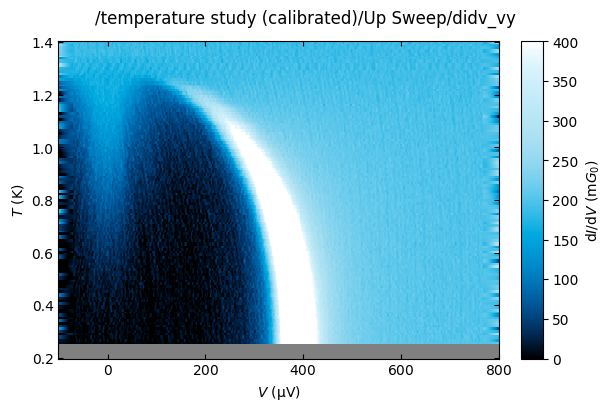

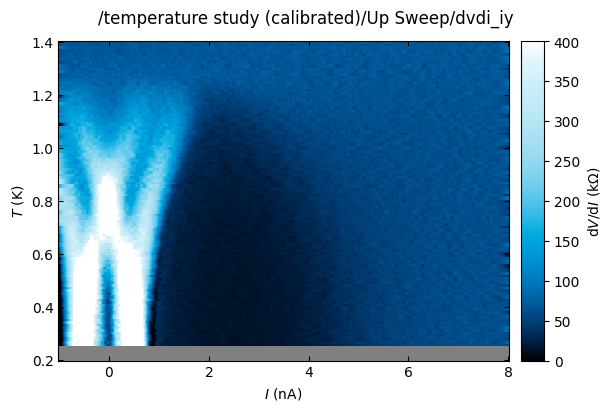

In [ ]:
# load and show calibrated exp data
%matplotlib inline

from utilities.ivplot import IVPlot
importlib.reload(sys.modules["utilities.ivplot"])
logger = logging.getLogger()
logger.setLevel(level=logging.WARNING)

eva = IVPlot()
eva.title = "temperature study (calibrated)"
eva.sub_folder = ""

eva.loadData()
eva.to_plot = eva.up_sweep
eva.title_of_plot = "Up Sweep"
eva.y_characters = [r"$T$", "K"]
eva.dvdi_norm = (1e3, 'k')
eva.didv_c_lim = (0, 0.4)
eva.dvdi_c_lim = (0, 0.4e6)
eva.smoothing = True
eva.window_length = 30
eva.plot_T = False
eva.plot_all()

In [ ]:
# Recalculate calibrated exp data
T_cal_K: NDArray = eva.mapped["temperature_axis"]
V_mV: NDArray = np.linspace(0, 0.7, 351)

V_mV_raw: NDArray = eva.mapped["voltage_axis"] * 1e3
I_exp_nA_raw: NDArray = eva.up_sweep["current"] * 1e9
G_exp_raw: NDArray = eva.up_sweep["differential_conductance"]

I_exp_nA_raw = savgol_filter(I_exp_nA_raw, 30, 2)
G_exp_raw = savgol_filter(G_exp_raw, 30, 2)

I_exp_nA = np.zeros((T_cal_K.shape[0], V_mV.shape[0]))
G_exp = np.zeros((T_cal_K.shape[0], V_mV.shape[0]))
for i, t in enumerate(T_cal_K):
    I_exp_nA[i, :] = bin_y_over_x(V_mV_raw, I_exp_nA_raw[i, :], V_mV)
    G_exp[i, :] = bin_y_over_x(V_mV_raw, G_exp_raw[i, :], V_mV)

from theory.models.dynes_jnp import thermal_energy_gap

Delta_T_meV: NDArray = np.array(thermal_energy_gap(Delta_meV=Delta_meV, T_K=T_cal_K))
Delta_T_meV[Delta_T_meV == 0.0] = np.nan

T_interest: NDArray = np.array([0.3, 0.8, 1, 1.1, 1.2, 1.25])

In [ ]:
# get dynes for calibrated T
I_dynes_nA: NDArray = get_I_nA(
    V_mV=V_mV,
    tau=tau,
    T_K=T_cal_K,
    Delta_meV=Delta_meV,
    Gamma_meV=Gamma_meV,
    model="dynes",
)
G_dynes: NDArray = np.gradient(I_dynes_nA, V_mV, axis=-1) / G_0_muS

Dynes: 100%|██████████| 241/241 [00:44<00:00,  5.46it/s]


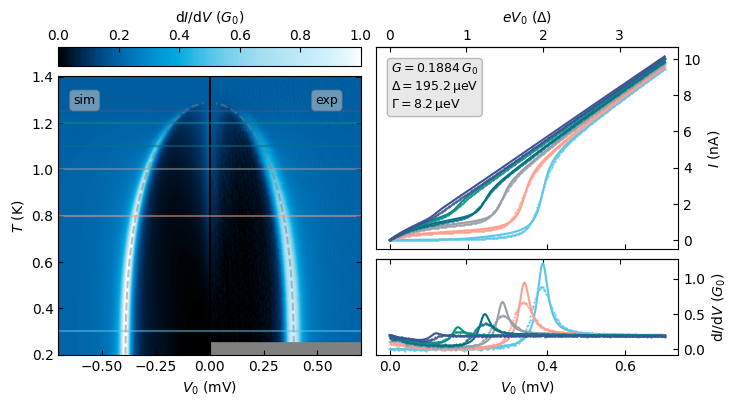

In [ ]:
# plot map comparison sim/exp

T = T_cal_K


def VtoE(V_mV):
    return V_mV / Delta_meV


def EtoV(E_meV):
    return E_meV * Delta_meV


V_label = r"$V_0$ (mV)"
E_label = r"$eV_0$ ($\Delta$)"
I_label = r"$I$ (nA)"
G_label = r"d$I/$d$V$ ($G_0$)"
y_label = r"$T$ (K)"

img_z = np.concatenate((np.flip(G_dynes[:, 1:], axis=1), G_exp), axis=1)
img_x = np.concatenate((-np.flip(V_mV[1:]), V_mV), axis=0)
img_y = T

dx, dy = img_x[-1] - img_x[-2], img_y[-1] - img_y[-2]
ext = (img_x[0] - dx / 2, img_x[-1] + dx / 2, img_y[0] - dy / 2, img_y[-1] + dy / 2)
clim = (
    np.nanmean(img_z) - 2 * np.nanstd(img_z),
    np.nanmean(img_z) + 2 * np.nanstd(img_z),
)
clim = (0, 1)

T_indices = []
for T_in in T_interest:
    T_indices.append(np.argmin(np.abs(T - T_in)))

# fig and axs
fig, axs = plt.subplots(
    figsize=(8, 4),
    nrows=3,
    ncols=2,
    height_ratios=(0.2, 1.8, 1),
    # sharex = True
)
plt.subplots_adjust(hspace=0.1, wspace=0.05)
ax_clb = axs[0, 0]

gs = axs[0, 1].get_gridspec()
for ax in axs[1:, 0]:
    ax.remove()
ax_img = fig.add_subplot(gs[1:, 0])

gs = axs[1, 0].get_gridspec()
for ax in axs[:2, 1]:
    ax.remove()
ax_i = fig.add_subplot(gs[:2, 1])

ax_g = axs[2, 1]

for ax in [ax_clb, ax_img, ax_i, ax_g]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=False,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )


im = ax_img.imshow(
    img_z,
    aspect="auto",
    origin="lower",
    clim=clim,
    extent=ext,
    interpolation=None,
    cmap=cmap(bad="grey"),
)
ax_img.vlines(0, ymin=ext[2], ymax=ext[3], color="k")
ax_img.plot(+2 * Delta_T_meV, T_cal_K, "--", color="grey", alpha=0.5)
ax_img.plot(-2 * Delta_T_meV, T_cal_K, "--", color="grey", alpha=0.5)

cbar = fig.colorbar(
    im,
    cax=ax_clb,
    label=G_label,
    orientation="horizontal",
    location="top",
)

ax_img_xlim = ax_img.get_xlim()
for i, T_i in enumerate(T_indices):
    color = colors[i]
    ax_i.plot(V_mV, I_exp_nA[T_i, :], ".", ms=1, color=color)
    ax_i.plot(V_mV, I_dynes_nA[T_i, :], "-", color=color)
    ax_g.plot(V_mV, G_exp[T_i, :], ".", ms=1, color=color)
    ax_g.plot(V_mV, G_dynes[T_i, :], "-", color=color)
    ax_img.plot(ax_img_xlim, (T_interest[i], T_interest[i]), alpha=0.5, color=color)


ax_i_2 = ax_i.secondary_xaxis("top", functions=(VtoE, EtoV))
ax_i_2.tick_params(direction="in", top=True)
ax_g_2 = ax_g.secondary_xaxis("top", functions=(VtoE, EtoV))
ax_g_2.tick_params(direction="in", top=True)

ax_i.xaxis.set_ticklabels([])
ax_g_2.xaxis.set_ticklabels([])

ax_g.yaxis.set_label_position("right")
ax_g.yaxis.tick_right()

ax_i.yaxis.set_label_position("right")
ax_i.yaxis.tick_right()

ax_img.set_ylabel(y_label)
ax_img.set_xlabel(V_label)
ax_g.set_xlabel(V_label)
ax_g.set_ylabel(G_label)
ax_i_2.set_xlabel(E_label)
ax_i.set_ylabel(I_label)

# add text box for the statistics
stats = (
    f"$G={tau:.4f}\\,G_0$\n"
    f"$\\Delta={Delta_meV*1e3:.1f}\\,$µeV\n"
    f"$\\Gamma={Gamma_meV*1e3:.1f}\\,$µeV"
)
bbox = dict(boxstyle="round", fc="lightgrey", ec="grey", alpha=0.5)
ax_i.text(
    0.05,
    0.7,
    stats,
    fontsize=9,
    bbox=bbox,
    transform=ax_i.transAxes,
    horizontalalignment="left",
)

ax_img.text(0.05, 0.9, "sim", fontsize=9, bbox=bbox, transform=ax_img.transAxes)
ax_img.text(0.85, 0.9, "exp", fontsize=9, bbox=bbox, transform=ax_img.transAxes)

fig.savefig("over_calibrated_T.png")